In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from datasets import DatasetDict

ds_path = "/mnt/ceph/users/sgolkar/datasets/astroclip/spec_rs_chunked_ds"
ds = DatasetDict.load_from_disk(ds_path)

In [3]:
from fillm.run.model import *

def load_model_from_ckpt(ckpt_path: str):
    """
    Load a model from a checkpoint.
    """
    if Path(ckpt_path).is_dir():
        ckpt_path = Path(ckpt_path) / "ckpt.pt"

    chkpt = torch.load(ckpt_path)
    config = chkpt["config"]
    state_dict = chkpt["model"]
    model_name = config["model"]['kind']
    model_keys = get_model_keys(model_name)
    # config['log_encoding']=False
    # config['log_decoding']=False
    # config['only_pred_masked']=True
    # config['first_layer_norm']=True
    # config['mlp_layer_norm']=True
    
    model_args = {k: config['model'][k] for k in model_keys}

    model_ctr, config_cls = model_registry[model_name]
    model_config = config_cls(**model_args)
    model = model_ctr(model_config)
    model.load_state_dict(state_dict)

    return {"model": model, "config": config}

model_path = "/mnt/home/sgolkar/ceph/saves/fillm/run-seqformer-2700314"
out = load_model_from_ckpt(model_path)

config = out['config']
model = out['model'].cpu()
model.eval()

print(model)


Seqformer(
  (data_embed): Linear(in_features=13, out_features=768, bias=True)
  (position_embed): Embedding(1556, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (layernorm1): LayerNorm()
      (attention): SelfAttention(
        (attention): Linear(in_features=768, out_features=2304, bias=True)
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
        (residual_dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm2): LayerNorm()
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (encoder): Linear(in_features=768, out_features=3072, bias=True)
        (decoder): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (final_layernorm): LayerNorm()
  (head): Linear(in_features=768, out_features=13, bias=True)
)


In [4]:
from fillm.run.processing import seq_collator_with_chunkedmasking

collator = seq_collator_with_chunkedmasking(num_chunks = config['dataset']['num_chunks'], chunk_width=config['dataset']['chunk_width'])

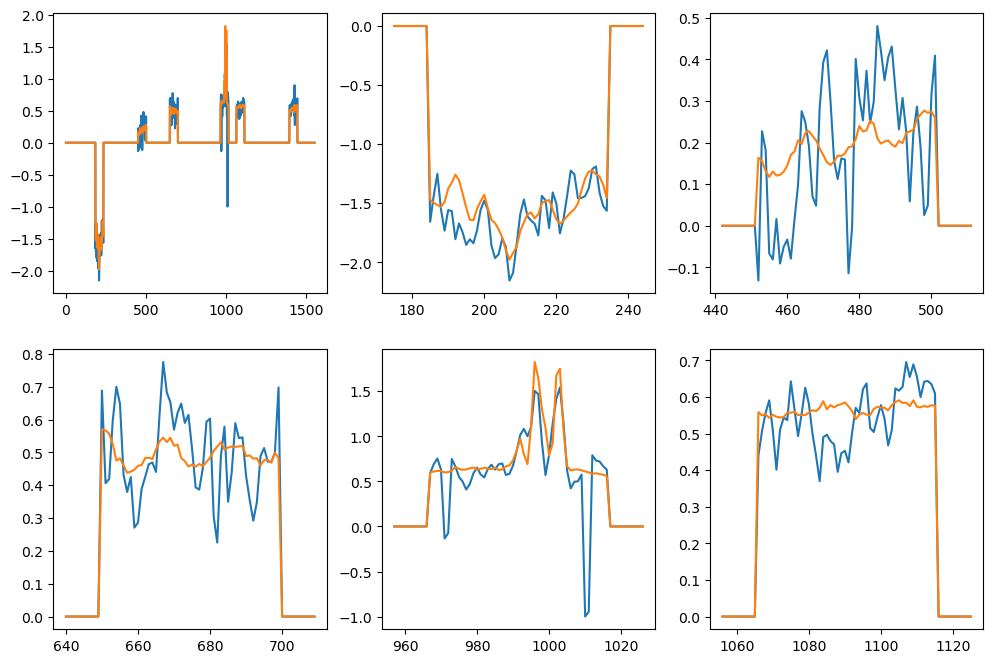

In [52]:
# set pytorch seed
torch.manual_seed(0)

# start a 2x3 figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# flatten the axs array
axs = axs.flatten()

sample = collator([ds['test'][0]])

x,y = sample['x'].squeeze(), sample['y'].squeeze()

pred = model(x=sample['x'])['preds'].squeeze()


input_ = x[1:,3:].mean(1)
target_ = y[1:,3:].mean(1)
pred_ = pred[1:,3:].data.mean(1)
loc = input_!= target_

axs[0].plot(target_*loc)
axs[0].plot(pred_*loc)
# plt.show()

input_ = x[1:,3:].mean(1)
target_ = y[1:,3:].mean(1)
pred_ = pred[1:,3:].data.mean(1)
loc = np.float32(input_!= target_)

start = loc.argmax()
for i in range(5):

    axs[i+1].plot(range(start-10,start+60), (target_*loc)[start-10:start+60])
    axs[i+1].plot(range(start-10,start+60), (pred_*loc)[start-10:start+60])
    start = start+60 + loc[start+60:].argmax()
    # plt.show()

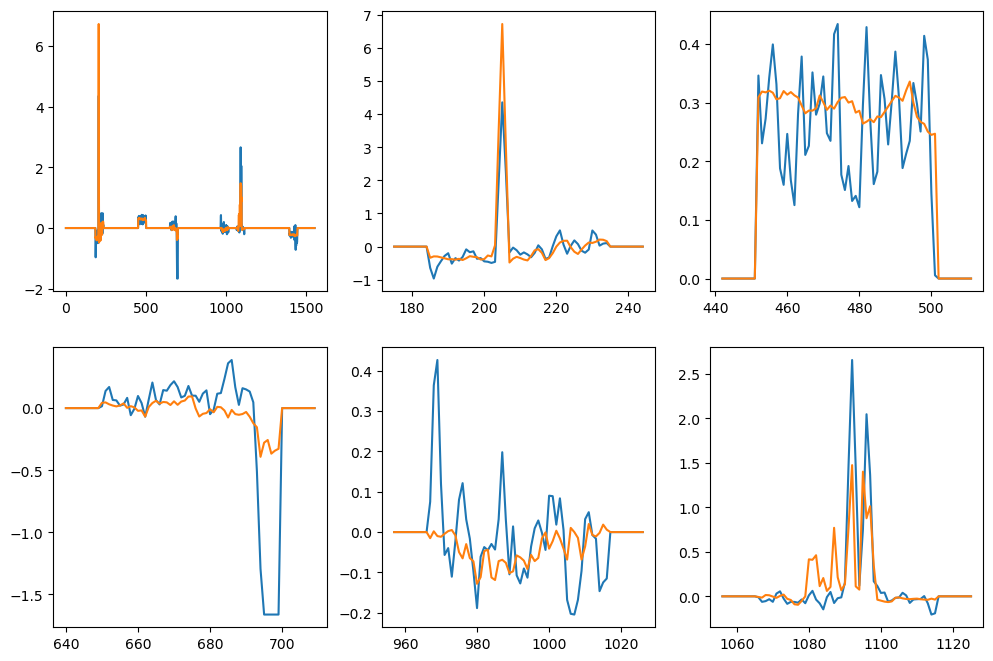

In [46]:
# set pytorch seed
torch.manual_seed(0)

# start a 2x3 figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# flatten the axs array
axs = axs.flatten()

sample = collator([ds['test'][1]])

x,y = sample['x'].squeeze(), sample['y'].squeeze()

pred = model(**sample)['preds'].squeeze()


input_ = x[1:,3:].mean(1)
target_ = y[1:,3:].mean(1)
pred_ = pred[1:,3:].data.mean(1)
loc = input_!= target_

axs[0].plot(target_*loc)
axs[0].plot(pred_*loc)
# plt.show()

input_ = x[1:,3:].mean(1)
target_ = y[1:,3:].mean(1)
pred_ = pred[1:,3:].data.mean(1)
loc = np.float32(input_!= target_)

start = loc.argmax()
for i in range(5):

    axs[i+1].plot(range(start-10,start+60), (target_*loc)[start-10:start+60])
    axs[i+1].plot(range(start-10,start+60), (pred_*loc)[start-10:start+60])
    start = start+60 + loc[start+60:].argmax()
    # plt.show()